Podejście:
- wygeneruj prostokat o najwiekszej wadze
    - sprawdź czy jest w kole
- wybierz chromosomy o największym zagęszczeniu środka (największa waga blisko środka)
- mutacja - przesuń centra prostokątów w stronę centrum

- wygeneruj prostokąt przy ściance randomowego prostokąta (pionowo lub poziomo)
    - zacznij od największego
    - sprawdź czy się mieści
- wybierz chromosomy o największym zamieszczeniu
- przesu centra prostokątów w stronę centrum ile się da




In [172]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

In [173]:
# helper functions

def intersects(s0,s1):
    # Return true if line segments AB and CD intersect
    dx0 = s0[1][0]-s0[0][0]
    dx1 = s1[1][0]-s1[0][0]
    dy0 = s0[1][1]-s0[0][1]
    dy1 = s1[1][1]-s1[0][1]
    p0 = dy1*(s1[1][0]-s0[0][0]) - dx1*(s1[1][1]-s0[0][1])
    p1 = dy1*(s1[1][0]-s0[1][0]) - dx1*(s1[1][1]-s0[1][1])
    p2 = dy0*(s0[1][0]-s1[0][0]) - dx0*(s0[1][1]-s1[0][1])
    p3 = dy0*(s0[1][0]-s1[1][0]) - dx0*(s0[1][1]-s1[1][1])
    return (p0*p1<0) & (p2*p3<0)

def point_in_rectangle(point, rect):
    # p for point
    ap_= np.array([point - rect.a_])
    bp_= np.array([point - rect.b_])
    ab_ap_ = rect.ab_v@ap_.T
    ab_ab_ = rect.ab_v@rect.ab_v.T
    bc_bp_ = rect.bc_v@bp_.T
    bc_bc_ = rect.bc_v@rect.bc_v.T
    return 0 < ab_ap_ and ab_ap_ < ab_ab_ and 0 < bc_bp_ and bc_bp_ < bc_bc_


def check_overlap(rect1, rect2):
    v_overlap = False
    h_overlap = False
    if (
        rect1.left <= rect2.left < rect1.right or
        rect1.left < rect2.right <= rect1.right or
        (rect2.left <=rect1.left and rect1.right <= rect2.right) 

    ):
        h_overlap = True
    if (
        rect1.bottom <= rect2.bottom < rect1.top or
        rect1.bottom < rect2.top <= rect1.top or
        (rect2.bottom <= rect1.bottom and rect1.top <= rect2.top)
    ):
        v_overlap = True
    return v_overlap and h_overlap



class Rectangle:
    
    def __init__(self, width, height, value):
        self.width = width
        self.height = height
        self.value = value
        self.area = width * height
        self.density = value / self.area
        self.update_coords(0, 0)
        

    def update_coords(self, x_center, y_center):
        '''
          ______________
        A|              |D
         |              |
         |              |
        B|______________|C
        '''
        self.center = (x_center, y_center)
        self.left = x_center - self.width / 2
        self.right = x_center + self.width / 2
        self.top = y_center + self.height / 2
        self.bottom = y_center - self.height / 2
        self.a_ = np.array((self.left, self.top))
        self.b_ = np.array((self.left, self.bottom))
        self.c_ = np.array((self.right, self.bottom))
        self.d_ = np.array((self.right, self.top))
        self.ab_ = np.array([self.b_, self.a_])
        self.bc_ = np.array([self.c_, self.b_])
        self.cd_ = np.array([self.d_, self.c_])
        self.da_ = np.array([self.a_, self.d_])

        
        self.ab_v = np.array([self.b_ - self.a_])
        self.bc_v = np.array([self.c_ - self.b_])
        
        
    def is_center_inside(self, other_rect):
        other_left = other_rect.left
        other_right = other_rect.right
        other_top = other_rect.top
        other_bottom = other_rect.bottom

        center_x, center_y = self.center
        
        if (
            other_left <= center_x <= other_right and
            other_bottom <= center_y <= other_top
        ):
            return True
        else:
            return False
                
        
    def copy_(self):
        return copy.deepcopy(self)
        
    def __repr__(self):
        return f"Rectangle({self.width}, {self.height}, {self.value}), center = {self.center}"
        
        

class CuttingStock:
    
    def __init__(self, radius, df,population_size, initial_chromosome_size=3, by_density=False,flip=True,exp=False):
        self.radius = radius
        self.by_density = by_density
        self.possible_members, self.probabilities = self.get_possible_members(df,flip=flip, exp = exp)
        self.max_edge = np.max([rect.width for rect in self.possible_members] + [rect.height for rect in self.possible_members])**2
        self.population_size = population_size
        self.population = []
        for i in range(population_size):
            new_chromosome = [self.generate_first_rect()]
            self.initial_generate(new_chromosome, initial_chromosome_size)
            self.population.append(new_chromosome)
        self.best_chromosome, self.best_fitness = self.get_most_fit(self.population)
        self.best_value_chromosome, self.best_value = self.get_best_value(self.population)
                    
            
            
    def fitness_function(self, chromosome, by_density=None, get_values=False):
        if by_density is None:
            by_density = self.by_density
        max_radius = 0
        values_sum = 0
        for rect in chromosome:
            values_sum += rect.density if by_density else rect.value 
            center_distance = np.linalg.norm(rect.center)
            if center_distance > max_radius:
                max_radius = center_distance
        if not get_values:
            return values_sum/(np.pi * max_radius**2)
        else:
            return values_sum
    
    def get_most_fit(self,population):
        
        fitnesses = []
        for chromosome in population:
            fitnesses.append(self.fitness_function(chromosome))
        fitnesses = np.array(fitnesses)
        best_chromosome = self.population[fitnesses.argmax()]
        best_fitness = fitnesses.max()
        return best_chromosome, best_fitness
    
    
    def get_best_value(self,population):
        values = []
        for chromosome in population:
            values.append(self.fitness_function(chromosome, get_values=True))
        values = np.array(values)
        best_value_chromosome = self.population[values.argmax()]
        best_value = values.max()
        return best_value_chromosome, best_value 
        
        
    
    def get_possible_members(self,df,flip=True, exp=False):
        possible_members = []
        probabilities = []
        overall_value = df[2].sum()
        if exp:
            overall_value = (df[2]**2).sum()
        if flip:
            overall_value *= 2
        df_rotated = df.copy()[[1, 0, 2]]
        for i, row in df.iterrows():
            rect = Rectangle(*row)
            value = rect.value
            if exp:
                value = rect.value**2
            probabilities.append(value / overall_value)
            possible_members.append(rect)
        #rotate rectangles  
        if flip:
            for i, row in df_rotated.iterrows():
                rect = Rectangle(*row)
                value = rect.value
                if exp:
                    value = rect.value**2
                probabilities.append(value / overall_value)
                possible_members.append(rect)
        
        return possible_members, np.array(probabilities)
        
    def generate_first_rect(self):
        rect = np.random.choice(self.possible_members, p=self.probabilities).copy_()
        random_coords = np.random.normal(0, np.max([rect.width, rect.height])/4, 2)
        rect.update_coords(*random_coords)
        return rect
        
    def in_circle(self, rect):
        if (
            np.sqrt(rect.left**2 + rect.top**2) > self.radius or
            np.sqrt(rect.left**2 + rect.bottom**2) > self.radius or
            np.sqrt(rect.right**2 + rect.top**2) > self.radius or
            np.sqrt(rect.right**2 + rect.bottom**2) > self.radius
        ):
            return False
        return True        
    
    def no_overlap(self, new_rect, old_rect):
        for new_edge in [new_rect.ab_, new_rect.bc_, new_rect.cd_, new_rect.da_]:
            for old_edge in [old_rect.ab_, old_rect.bc_, old_rect.cd_, old_rect.da_]:
                if intersects(new_edge, old_edge):
                    return False
        return True
    
    
    def valid(self, new_rect, chromosome, generated=False):
        if not self.in_circle(new_rect):
            return False
        
        potential_overlap = [rect for rect in chromosome if rect is not None and np.linalg.norm(np.array(new_rect.center) - np.array(rect.center)) <= self.max_edge]
        for rect in potential_overlap:
            if check_overlap(new_rect, rect):# and check_overlap(rect, new_rect):
                return False
            # if generated and  point_in_rectangle(np.array(new_rect.center), rect):
            #     return False
            # if generated and (rect.is_center_inside(new_rect) or new_rect.is_center_inside(rect)):
            #     return False
            # if not self.no_overlap(new_rect, rect):
            #     return False
        return True
    
    
    
    def generate_adjacent_rectangle(self, rect, chromosome):
        new_rect = np.random.choice(self.possible_members, p=self.probabilities).copy_()
        offset_x = np.random.uniform(-rect.width/2, rect.width/2)
        offset_y = np.random.uniform(-rect.height/2, rect.height/2)
        perm = np.random.permutation(4)
        for i in perm:
            # 0 - top, 1 - bottom, 2 - left, 3 - right
            if i == 0:
                new_rect.update_coords(rect.center[0] + offset_x, rect.top+np.ceil(new_rect.height/2))
            elif i == 1:
                new_rect.update_coords(rect.center[0] + offset_x, rect.bottom-np.ceil(new_rect.height/2))
            elif i == 2:
                new_rect.update_coords(rect.left-np.ceil(new_rect.width/2), rect.center[1] + offset_y)
            elif i == 3:
                new_rect.update_coords(rect.right+np.ceil(new_rect.width/2), rect.center[1] + offset_y)
            if self.valid(new_rect, chromosome, generated=True):
                return new_rect
        return None
    
    
    def initial_generate(self, new_chromosome,initial_chromosome_size):
        while len(new_chromosome) < initial_chromosome_size:
            choice = np.random.choice(new_chromosome)
            rect = self.generate_adjacent_rectangle(choice, new_chromosome)
            if rect is not None:
                new_chromosome.append(rect)
    
    
    
    
    def mutate(self, chromosome, shift_by=0.5):
        initial_chromosome_length = len(chromosome)
        for i,rect in enumerate(chromosome):
            chromosome[i] = None
            self.move_to_center(rect, chromosome,shift_by=shift_by)
            chromosome[i] = rect
            new_rect = self.generate_adjacent_rectangle(rect, chromosome)
            if new_rect is not None:
                chromosome.append(new_rect)
            # if i == initial_chromosome_length - 1:
            #     break
        
                
                
    
    def move_to_center(self, rect, chromosome,shift_by):
        saved_center = rect.center
        shifts = np.sign(rect.center)*shift_by
        rect.update_coords(rect.center[0] - shifts[0], rect.center[1] )
        if not self.valid(rect, chromosome):
            rect.update_coords(*saved_center) # go back to previous position
        saved_center = rect.center
        rect.update_coords(rect.center[0], rect.center[1] - shifts[1])
        if not self.valid(rect, chromosome):
            rect.update_coords(*saved_center)
    
    
    def pick_elite(self, chromosomes, elite_coef):
        fitnesses = []
        for chromosome in self.population:
            fitnesses.append(self.fitness_function(chromosome))
        fitnesses = np.array(fitnesses)
        probabilities = fitnesses / np.sum(fitnesses)
        
        elite_index = np.random.choice(self.population_size, size=int(elite_coef * self.population_size), p=probabilities, replace=False)
        elite = np.array(self.population, dtype=object)[elite_index]
        elite = elite.tolist()
        return elite
    
    
    
    
    def evolve(self, generations_number,shift_by=0.5, verbose=True, elite_coef=1):
        for generation in range(generations_number+1):
            # self.visualise(generation=generation)
            self.best_chromosome, self.best_fitness = self.get_most_fit(self.population)
            self.best_value_chromosome, self.best_value = self.get_best_value(self.population)

            elite = self.pick_elite(self.population, elite_coef)
            offspring = elite
            while len(offspring) < self.population_size:
                choice = np.random.choice(len(elite))
                offspring.append(copy.deepcopy(elite[choice]))
            self.population = offspring
                

            for chromosome in self.population:
                self.mutate(chromosome, shift_by=shift_by)
                
                
            
            
            if verbose and generation % 10 == 0:
                self.visualise(generation=generation)
    
    
    
    

    def visualise(self, text_=True, figsize=(4, 4), dpi=120, generation=None):
        plt.figure(figsize=figsize, dpi=dpi)
        x = np.linspace(-self.radius, self.radius, self.radius*4)
        plt.plot(x, np.sqrt(self.radius**2 - x**2), c="black", linewidth=1)
        plt.plot(x, -np.sqrt(self.radius**2 - x**2), c="black", linewidth=1)
        plt.plot(0,0, c="red", marker="o", markersize=3)
        value_sum = 0
        for rect in self.best_chromosome:
            plt.plot([rect.left,rect.left,rect.right,rect.right, rect.left],[rect.top,rect.bottom,rect.bottom,rect.top, rect.top]  , c='blue', linewidth=0.7)
            if text_:
                plt.text(*rect.center,str(rect.value), size=7, horizontalalignment='center', verticalalignment='center')
            value_sum += rect.value
        if generation is not None:
            plt.title(f"Generation: {generation}, Value: {value_sum}")
        else:
            plt.title(f"Value: {value_sum}")
        plt.show()
    
    100

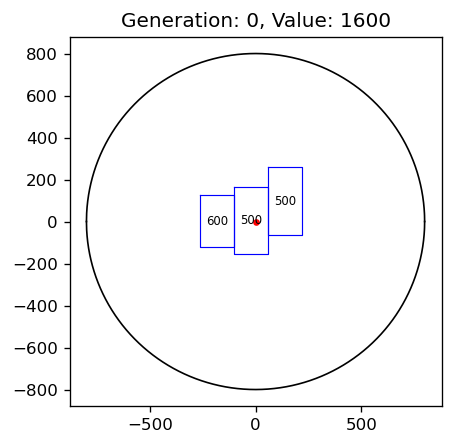

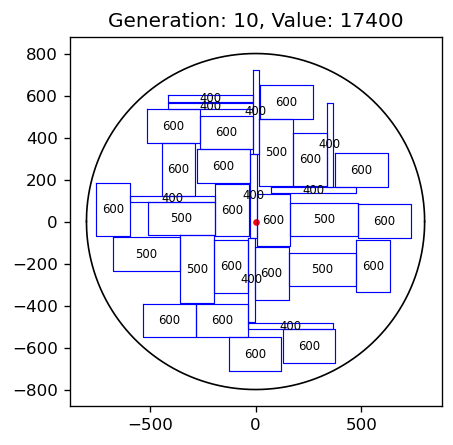

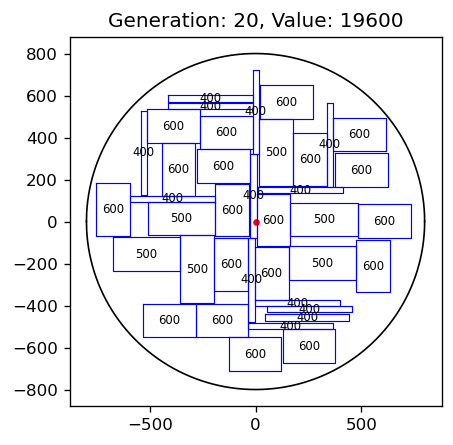

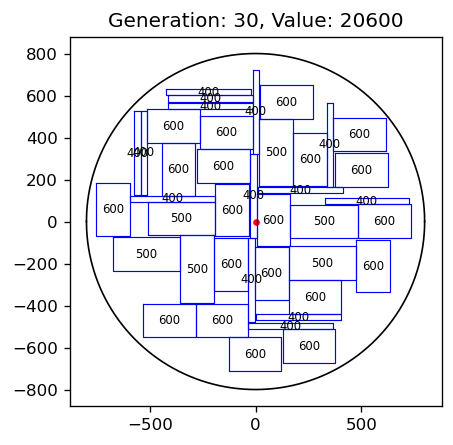

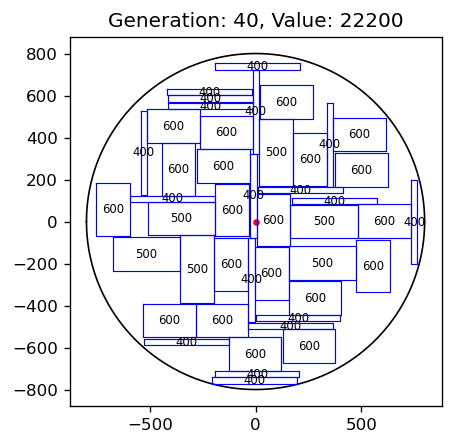

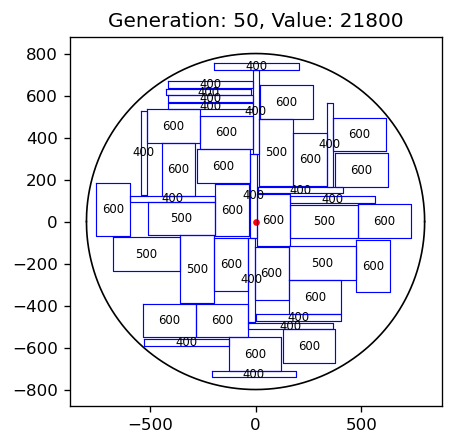

In [174]:

df = pd.read_csv('cutting/r800.csv', header=None)
cs = CuttingStock(radius=800, df=df,population_size=20, initial_chromosome_size=3, by_density=False, flip=True, exp=True)
cs.evolve(50, shift_by=10, verbose=True, elite_coef=0.5)

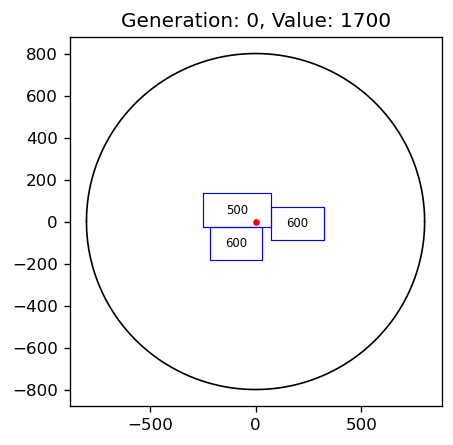

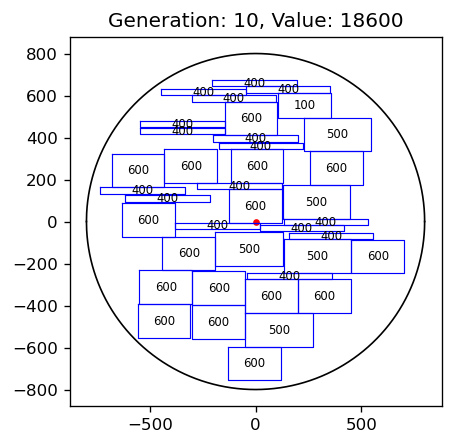

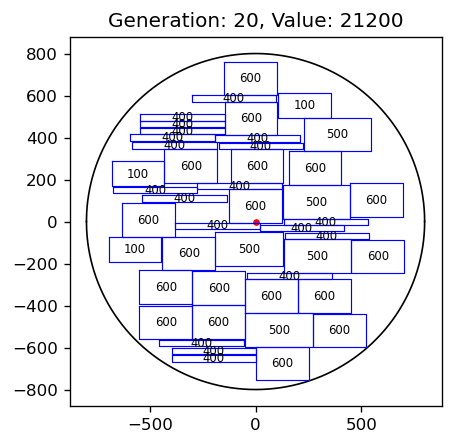

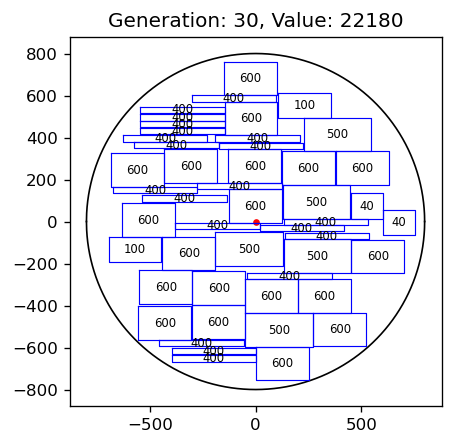

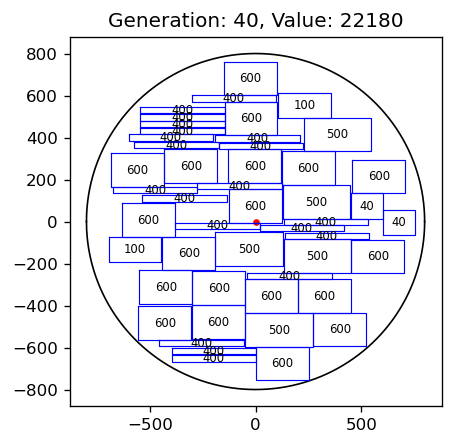

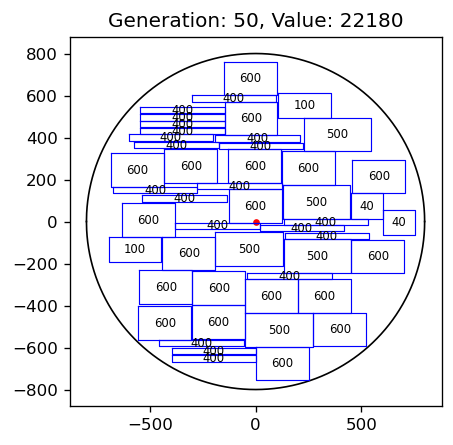

In [175]:

df = pd.read_csv('cutting/r800.csv', header=None)
cs = CuttingStock(radius=800, df=df,population_size=20, initial_chromosome_size=3, by_density=False, flip=False, exp=True)
cs.evolve(50, shift_by=10, verbose=True, elite_coef=0.5)

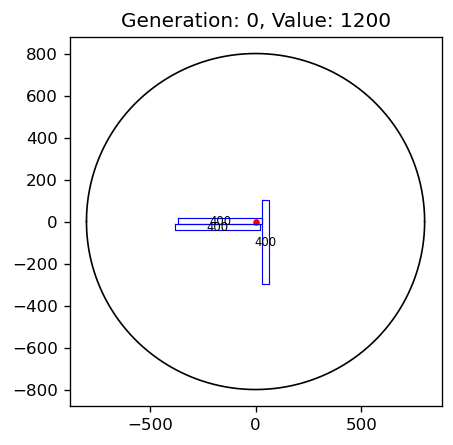

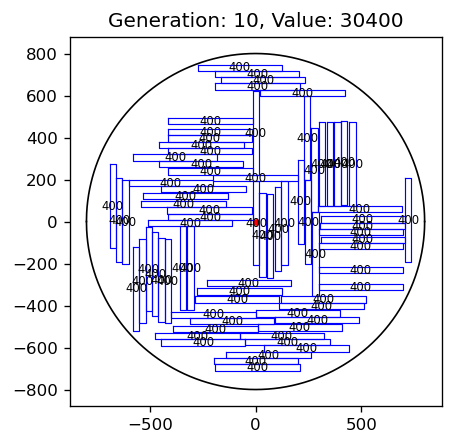

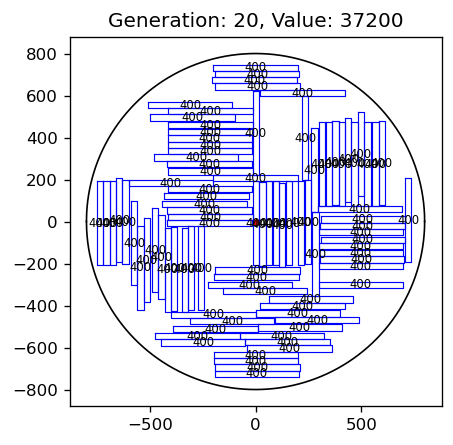

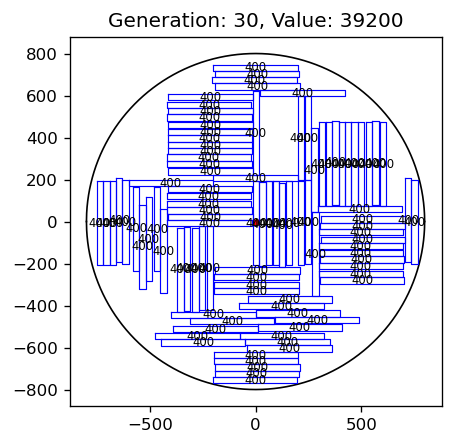

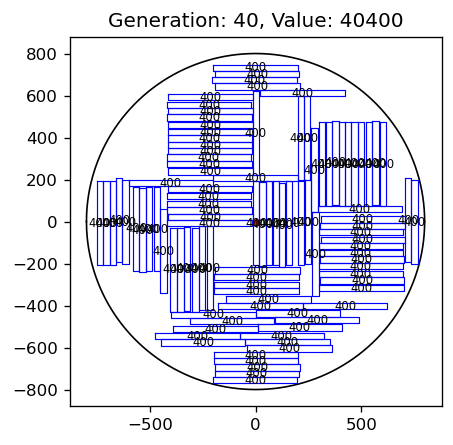

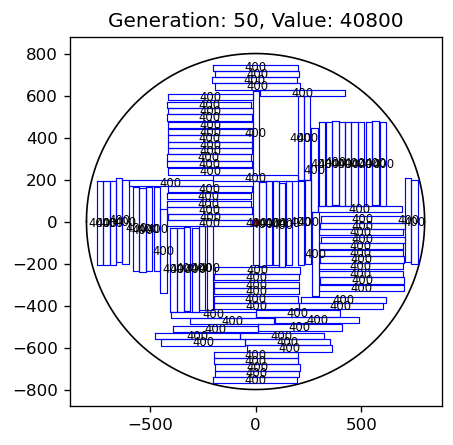

In [176]:
df = pd.read_csv('cutting/r800.csv', header=None)
df = df.iloc[[4],:]
cs = CuttingStock(radius=800, df=df,population_size=20, initial_chromosome_size=3, by_density=False, flip=True)
cs.evolve(50, shift_by=10, verbose=True, elite_coef=0.5)

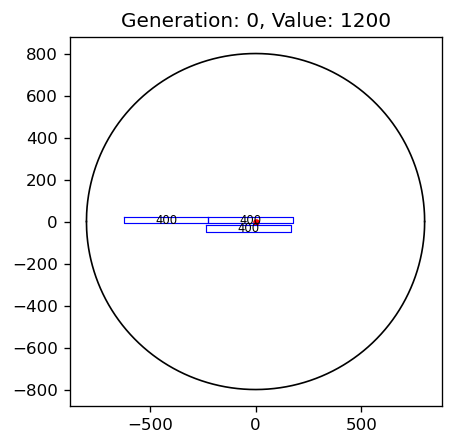

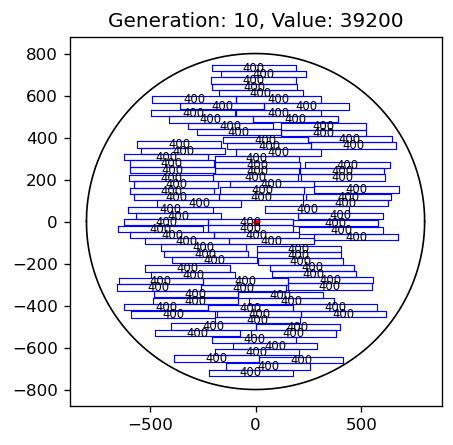

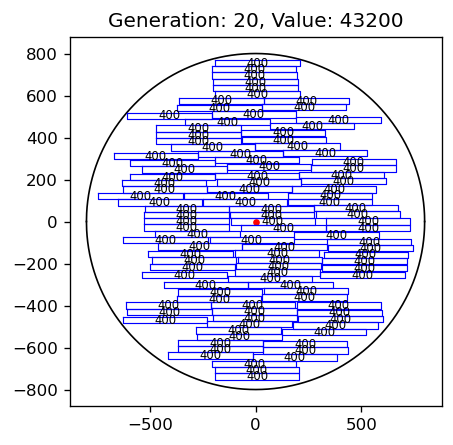

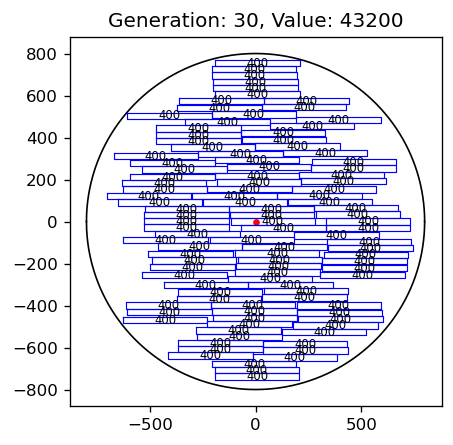

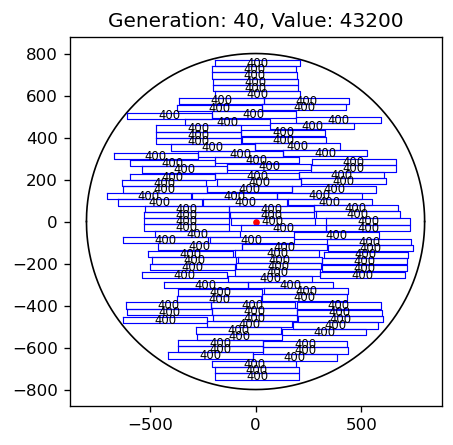

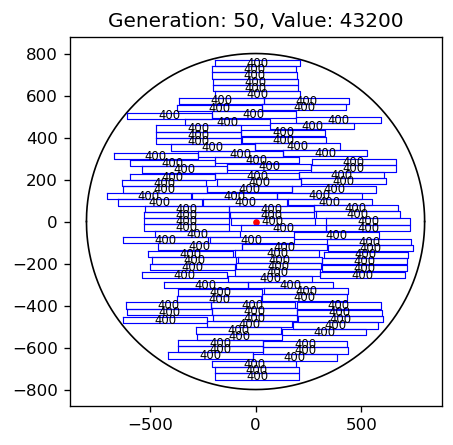

In [177]:
df = pd.read_csv('cutting/r800.csv', header=None)
df = df.iloc[[4],:]
cs = CuttingStock(radius=800, df=df,population_size=2, initial_chromosome_size=3, by_density=False, flip=False)
cs.evolve(50, shift_by=10, verbose=True, elite_coef=1)

## 1200

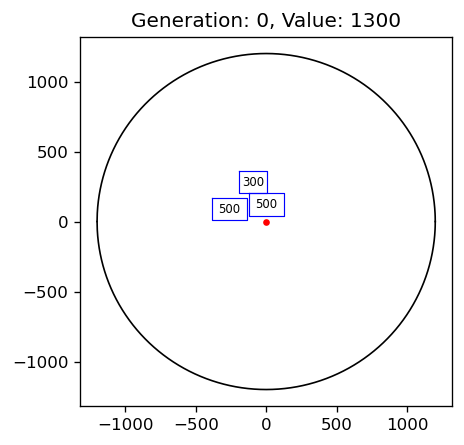

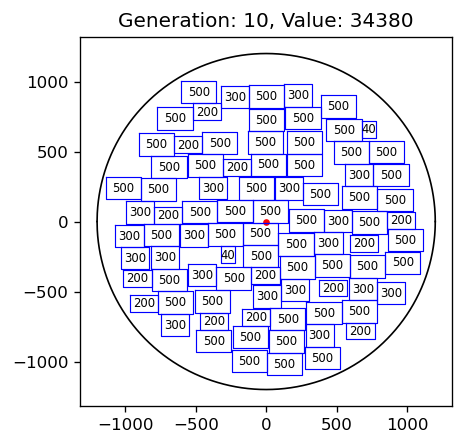

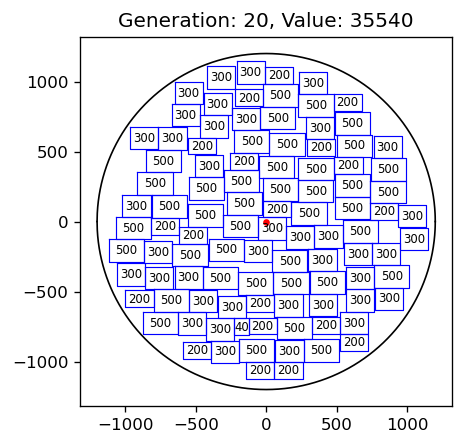

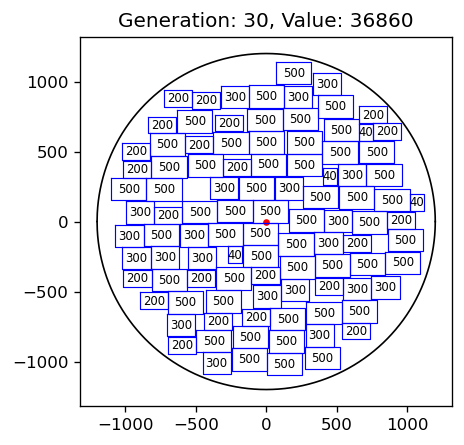

In [181]:
df = pd.read_csv('cutting/r1200.csv', header=None)
cs = CuttingStock(radius=1200, df=df,population_size=10, initial_chromosome_size=3, by_density=False, flip=False, exp=True)
cs.evolve(30, shift_by=10, verbose=True, elite_coef=0.5)

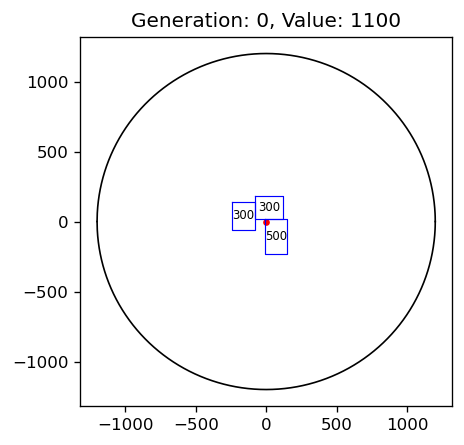

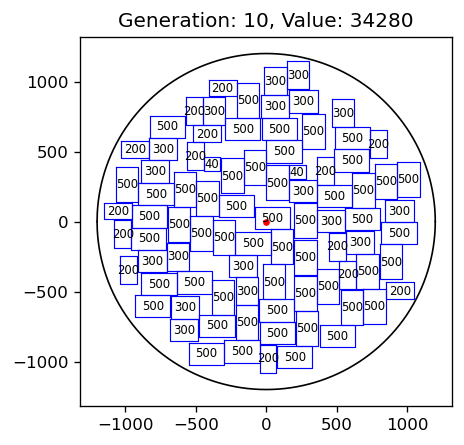

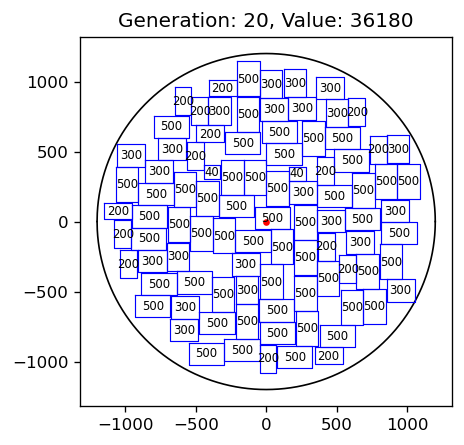

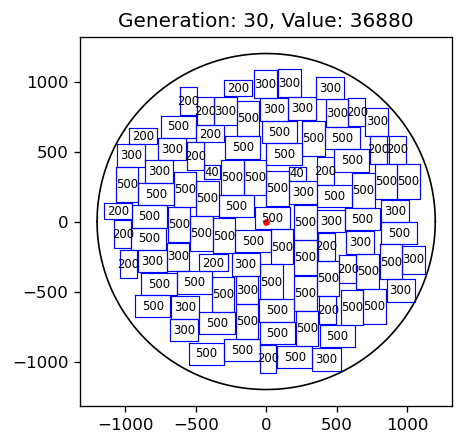

In [182]:
df = pd.read_csv('cutting/r1200.csv', header=None)
cs = CuttingStock(radius=1200, df=df,population_size=10, initial_chromosome_size=3, by_density=False, flip=True, exp=True)
cs.evolve(30, shift_by=10, verbose=True, elite_coef=0.5)

## 1000

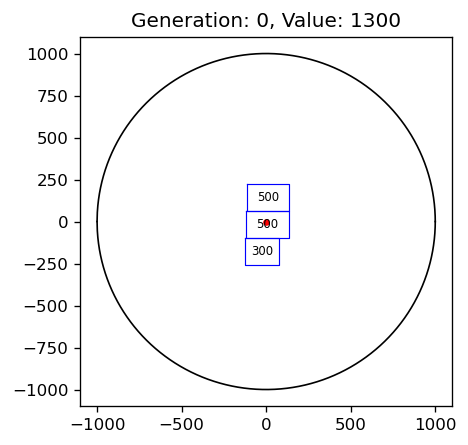

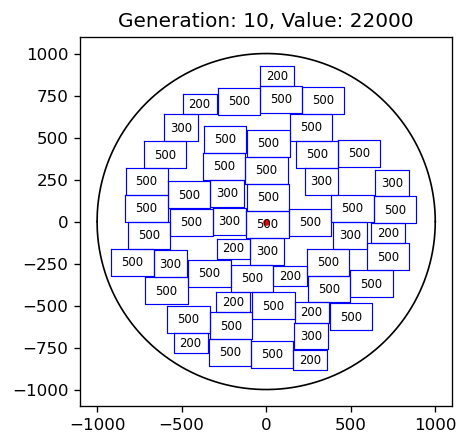

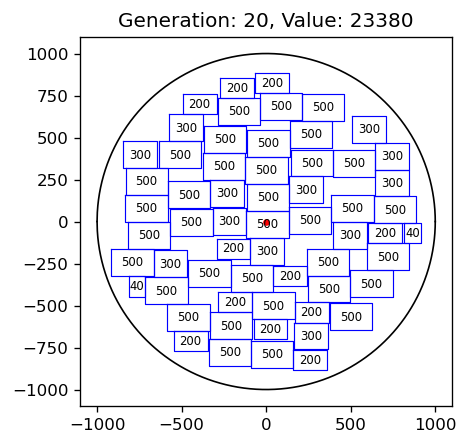

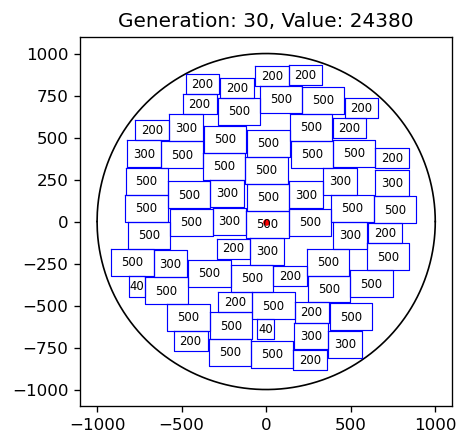

In [183]:
df = pd.read_csv('cutting/r1000.csv', header=None)
cs = CuttingStock(radius=1000, df=df,population_size=10, initial_chromosome_size=3, by_density=False, flip=False, exp=True)
cs.evolve(30, shift_by=10, verbose=True, elite_coef=0.5)

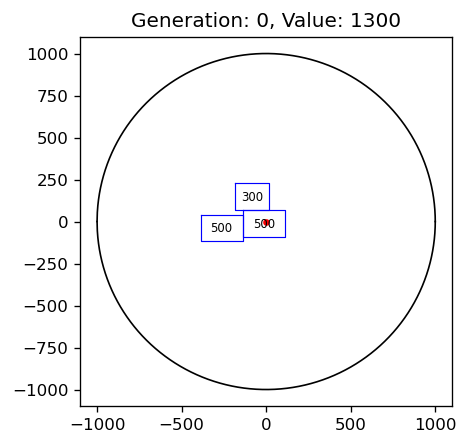

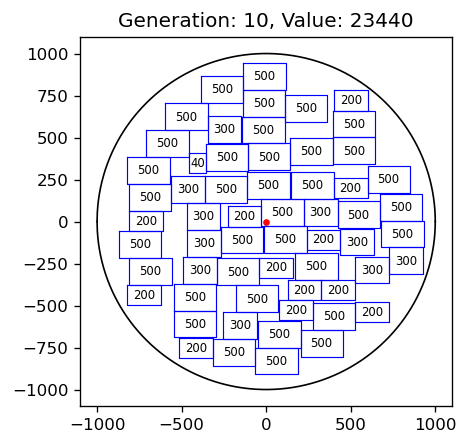

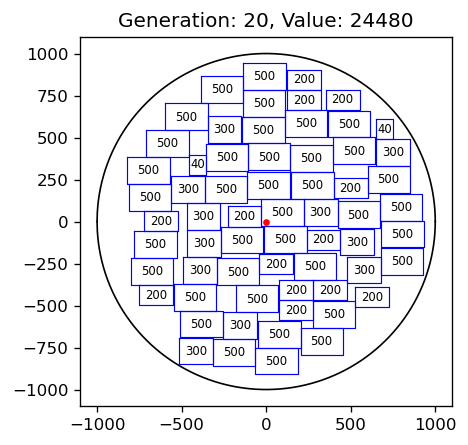

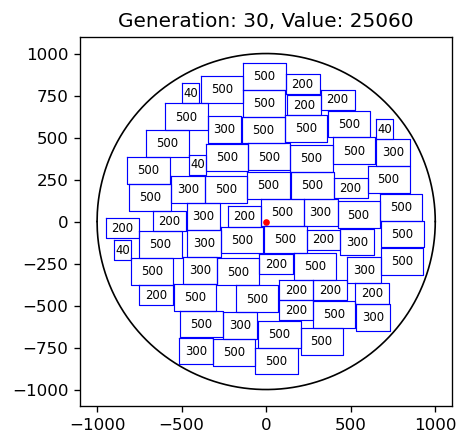

In [184]:
df = pd.read_csv('cutting/r1000.csv', header=None)
cs = CuttingStock(radius=1000, df=df,population_size=10, initial_chromosome_size=3, by_density=False, flip=False, exp=True)
cs.evolve(30, shift_by=10, verbose=True, elite_coef=0.5)

## 1100

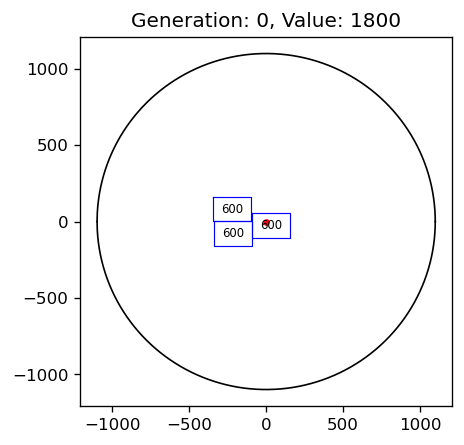

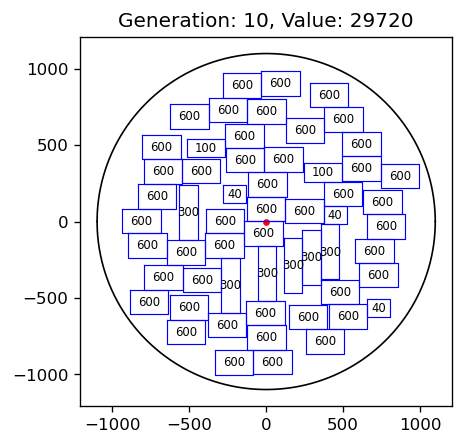

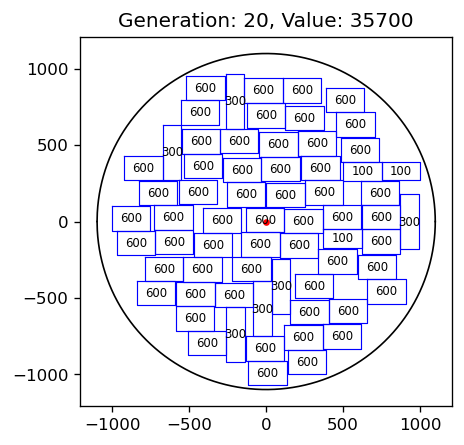

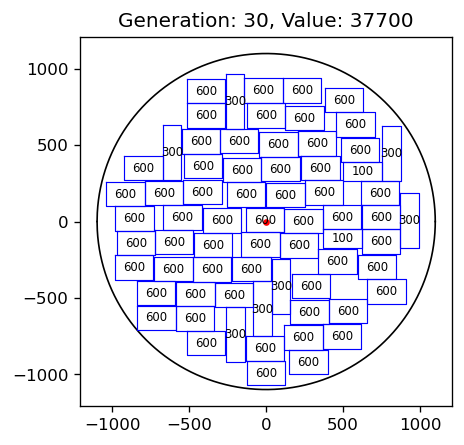

In [185]:
df = pd.read_csv('cutting/r1100.csv', header=None)
cs = CuttingStock(radius=1100, df=df,population_size=10, initial_chromosome_size=3, by_density=False, flip=False, exp=True)
cs.evolve(30, shift_by=10, verbose=True, elite_coef=0.5)

## 850

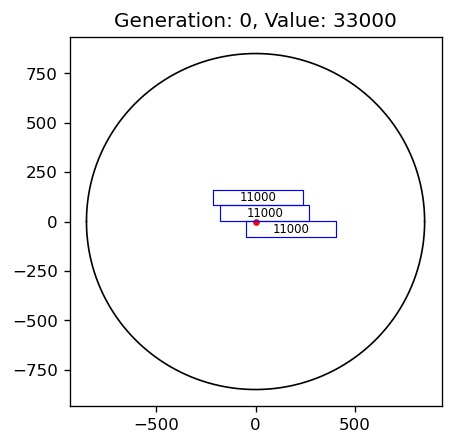

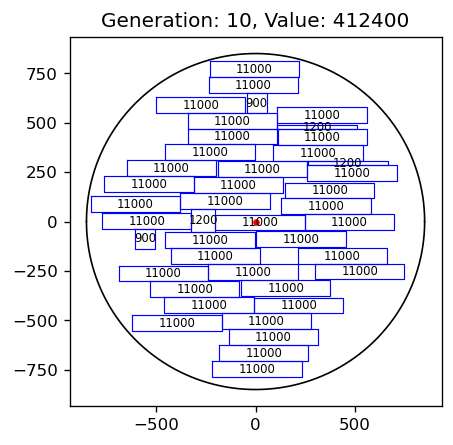

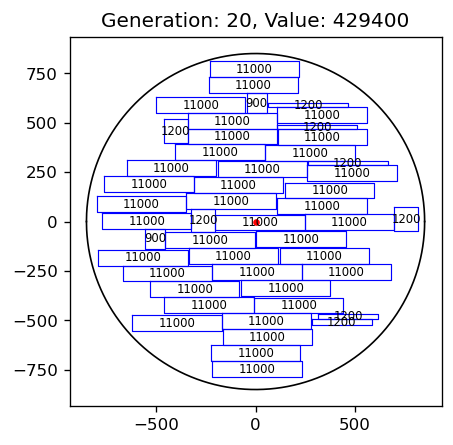

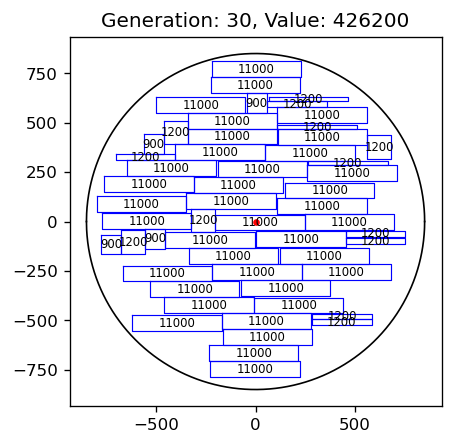

In [186]:
df = pd.read_csv('cutting/r850.csv', header=None)
cs = CuttingStock(radius=850, df=df,population_size=10, initial_chromosome_size=3, by_density=False, flip=False, exp=True)
cs.evolve(30, shift_by=10, verbose=True, elite_coef=0.5)